In [1]:
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

## FUNCTIONS

In [3]:
def result_control(train_true_values, train_pred_values, test_true_values, test_pred_values):

    text_train = 'R2 = ' + \
        str(round(r2(train_true_values, train_pred_values), 3))
    text_test = 'R2 = ' + str(round(r2(test_true_values, test_pred_values), 3))
    d_out = pd.DataFrame({'Price1': train_true_values,
                          'Price2': train_pred_values})
    d_out['delta'] = abs(d_out['Price1'] - d_out['Price2']
                         ) / d_out['Price1'] * 100
    d_out_sc = d_out[d_out['delta'] > 100]
    fig, ax = plt.subplots(nrows=2, ncols=1)
    ax1, ax2 = ax.flatten()
    fig.set_size_inches(9, 18)
    box_1 = {'facecolor': 'white',
             'edgecolor': 'k',
             'boxstyle': 'round'}
    ax1.set_title("Prediction on train values")
    ax1.set_xlabel('Predicted vales')
    ax1.set_ylabel('Real vales')
    ax1.scatter(train_pred_values, train_true_values,
                edgecolors='white', s=55, c='dimgray')
    ax1.scatter(d_out_sc['Price2'], d_out_sc['Price1'],
                edgecolors='white', s=55, c='darkred')
    ax1.plot([0, max(train_true_values)], [0, max(train_true_values)], 'b--')
    ax1.text(100000, 550000, text_train,
             bbox=box_1,
             horizontalalignment='center',
             color='k',
             fontsize=30, fontweight="bold", family='Times New Roman')
    ax2.set_title("Prediction on test values")
    ax2.scatter(test_pred_values, test_true_values,
                edgecolors='white', s=55, c='dimgray')
    ax2.plot([0, 600000], [0, 600000], 'b--')
    ax2.text(100000, 550000, text_test,
             bbox=box_1,
             horizontalalignment='center',
             color='k',
             fontsize=30, fontweight="bold", family='Times New Roman')
    fig.subplots_adjust(hspace=0.2)

In [4]:
def n_value_control(data_f, col_name: str, group_list: list = [], func=1):
    """
    Обработка выбросов и NaN заначений
    :param df: DataFrame
    :param col_name: название столбца
    :param cor_method: способ обработки (1 - медиана, 2 - мода, 3 - среднее)
    :return: DataFrame group by condition 
    """
    if func == 1:
        ddf = data_f.groupby(group_list)[col_name].median()
    if func == 2:
        ddf = data_f.groupby(group_list)[col_name].agg(lambda x: mode(x)[0])
    if func == 3:
        ddf = data_f.groupby(group_list)[col_name].mean()
    ddf = pd.DataFrame(ddf)
    ddf.rename(columns={col_name: 'cor_col'}, inplace=True)
    return ddf

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

## Load data, memory control

In [6]:
df_train = reduce_mem_usage(pd.read_csv('train.csv'))
df_train.drop(df_train[df_train.HouseYear > 2020].index,
              inplace=True)  # для снижения вероятности ошибок при обучении модели
# так как выбросы HouseYear только в трейне

X_test = reduce_mem_usage(pd.read_csv('test.csv'))
y_train = df_train[['Price']]
dff_train = df_train
df_train[['Rooms', 'HouseFloor']] = df_train[[
    'Rooms', 'HouseFloor']].astype('int8')
df_train[['Rooms', 'HouseFloor']] = df_train[[
    'Rooms', 'HouseFloor']].astype('int8')
df_train.drop(columns='Id', inplace=True)
df_train['DistrictId'] = df_train['DistrictId'].astype('category')


df_to_send = pd.DataFrame()
df_to_send['Id'] = X_test['Id']
X_test.set_index('Id', inplace=True)
df_to_send.set_index('Id', inplace=True)

X_test[['Rooms', 'HouseFloor']] = X_test[[
    'Rooms', 'HouseFloor']].astype('int8')
X_test[['Rooms', 'HouseFloor']] = X_test[[
    'Rooms', 'HouseFloor']].astype('int8')
X_test['DistrictId'] = X_test['DistrictId'].astype('category')

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


## EDA

In [7]:
df_train['DistrictId'].describe()

count     9998
unique     205
top         27
freq       851
Name: DistrictId, dtype: int64

In [8]:
X_test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00,5000.00,3959.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,2623.00,5000.00,5000.00
mean,1.91,56.45,36.16,5.98,8.63,12.60,1984.39,0.12,24.93,5406.90,8.26,1146.66,1.32,4.24
std,0.84,19.09,17.83,9.95,5.48,6.79,18.57,0.12,17.53,4026.61,23.86,1044.75,1.48,4.78
min,0.00,1.38,0.33,0.00,1.00,0.00,1908.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00
25%,1.00,41.91,23.09,1.00,4.00,9.00,1973.00,0.02,6.00,1564.00,0.00,325.00,0.00,1.00
50%,2.00,52.92,32.93,6.00,7.00,12.00,1977.00,0.07,25.00,5285.00,2.00,900.00,1.00,3.00
75%,2.00,66.29,45.17,9.00,12.00,17.00,2000.00,0.20,36.00,7287.00,5.00,1548.00,2.00,6.00
max,17.00,223.45,303.07,620.00,78.00,99.00,2020.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00


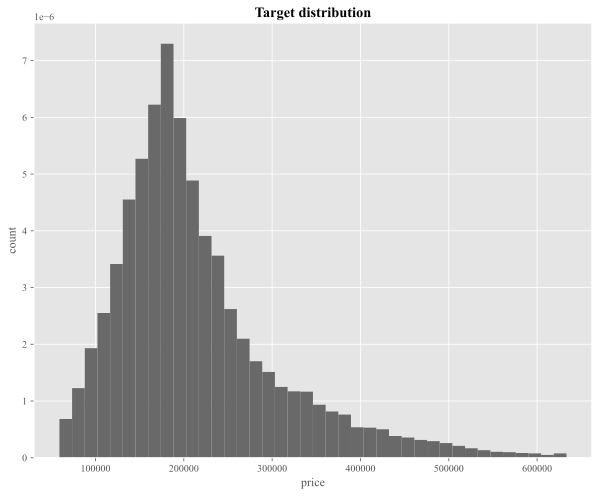

In [9]:
plt.figure(figsize=(10, 8))
df_train['Price'].hist(density=True, bins=40, color='dimgray')
plt.ylabel('count')
plt.xlabel('price')
plt.title('Target distribution', fontweight="bold")
plt.show()

## Handling outliers. Data preprocessing

In [10]:
class PipelinePreparation:

    def __init__(self):

        self.Square_control = None
        self.Rooms_control = None
        self.LifeSquare_control = None
        self.KitchenSquare_control = None
        self.HouseFloor_control = None
        self.medians = None

    def df_outliers(self, X):  # определение выбросов

        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6) | (
            X['Square'] / X['Rooms'] < 6), 'Rooms'] = np.nan
        X.loc[(X['Square'] < 20.2) | (X['Square'] > 275) | (
            X['Square'] < X['LifeSquare']), 'Square'] = np.nan
        X.loc[(X['KitchenSquare'] < 2) | (
            X['KitchenSquare'] > 12), 'KitchenSquare'] = np.nan
        X.loc[(X['HouseFloor'] == 0) | (
            X['HouseFloor'] > 95), 'HouseFloor'] = np.nan
        X.loc[(X['Floor'] == 0) | (
            X['Floor'] > 95), 'HouseFloor'] = np.nan
        X.loc[(X['HouseYear'] < 1908) | (
            X['HouseYear'] > 2020), 'HouseFloor'] = 2020

        X['SL'] = X['LifeSquare'] / X['Square']
        X.loc[(X['LifeSquare'] < 19) | (X['LifeSquare'] > 275) |
              (X['SL'] < X['SL'].quantile(q=0.1)) |
              (X['SL'] > X['SL'].quantile(q=0.87)) |  
              (X['LifeSquare'] > X['Square']), 'LifeSquare'] = np.nan # квантили по кросс-валидации

    def df_to_fill(self, X):  # определение значений для заполнения пропусков/выбросов

        self.medians = X.median()
        self.HouseFloor_control = n_value_control(
            X, 'HouseFloor', ['DistrictId', 'HouseYear'], 2)
        self.HouseFloor_control[self.HouseFloor_control.isna()] = n_value_control(
            X, 'HouseFloor', ['HouseYear'], 2)

        self.Square_control = n_value_control(
            X, 'Square', ['HouseYear', 'Rooms'], 1)
        self.Square_control[self.Square_control.isna()] = n_value_control(
            X, 'Square', ['Rooms'], 1)

        self.KitchenSquare_control = n_value_control(
            X, 'KitchenSquare', ['HouseYear', 'Rooms'], 2)
        self.KitchenSquare_control[self.KitchenSquare_control.isna()] = n_value_control(
            X, 'KitchenSquare', ['Rooms'], 2)

        bins = np.linspace(20, 280, 13)
        X['Sc_cut'] = pd.cut(X['Square'], bins=bins, labels=False)
        self.Rooms_control = n_value_control(X, 'Rooms', ['Sc_cut'], 2)

        self.LifeSquare_control = n_value_control(X, 'SL', ['Rooms'], 1)

    def gap_filling(self, X):  # функция заполнения

        if 'Sc_cut' not in X.columns:
            bins = np.linspace(20, 280, 13)
            X['Sc_cut'] = pd.cut(X['Square'], bins=bins, labels=False)

        X = pd.merge(X, self.Square_control['cor_col'],  how='left', left_on=['HouseYear', 'Rooms'],
                     right_on=['HouseYear', 'Rooms'])
        X.loc[X['Square'].isna(), 'Square'] = X['cor_col']
        X.drop('cor_col', axis='columns', inplace=True)

        X['Fl'] = 0
        X.loc[X['HouseFloor'] < X['Floor'], 'Fl'] = X['Floor']
        X.loc[X['HouseFloor'] < X['Floor'], 'Floor'] = X['HouseFloor']
        X.loc[X['Fl'] == 1, 'HouseFloor'] = X['Fl']
        X.drop(columns='Fl', inplace=True)

        X = pd.merge(X, self.HouseFloor_control['cor_col'],  how='left', left_on=['DistrictId', 'HouseYear'],
                     right_on=['DistrictId', 'HouseYear'])
        X.loc[X['HouseFloor'].isna(), 'HouseFloor'] = X['cor_col']
        X.drop('cor_col', axis='columns', inplace=True)

        X = pd.merge(X, self.KitchenSquare_control['cor_col'],  how='left', left_on=['HouseYear', 'Rooms'],
                     right_on=['HouseYear', 'Rooms'])
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = X['cor_col']
        X.drop('cor_col', axis='columns', inplace=True)

        X = pd.merge(X, self.Rooms_control['cor_col'],  how='left', left_on=[
            'Sc_cut'], right_on=['Sc_cut'])
        X.loc[X['Rooms'].isna(), 'Rooms'] = X['cor_col']
        X.drop('cor_col', axis='columns', inplace=True)

        X = pd.merge(X, self.LifeSquare_control['cor_col'],  how='left', left_on=['Rooms'],
                     right_on=['Rooms'])
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X['cor_col'] * \
            X['Square']
        X.drop('cor_col', axis='columns', inplace=True)

        X.fillna(self.medians, inplace=True)

        return X

    # построение диаграм зависимости целевой переменной
    def target_analysis(self, X, colomn_list: list):
        """
        target dependency diagrams 
        """

        X['target'] = X['Price'] / X['Square']
        fig = plt.figure(figsize=(20, 10))
        total_axes = len(colomn_list)
        subplt = 1
        for x in colomn_list:
            ax = fig.add_subplot(total_axes, 1, subplt)
            df_vis = pd.DataFrame(X.groupby(by=x, as_index=False, )[
                'target'].median(), columns=[x, 'target'])
            df_vis = df_vis.sort_values(by='target')
            sns.barplot(y=df_vis['target'], x=df_vis[x], data=df_vis,
                        orient='v', palette='coolwarm', order=df_vis[x])
            plt.xlabel(x, fontsize=12, weight='bold')
            plt.ylabel('Medium price per square meter', fontsize=10)
            plt.xticks(rotation=90)
            plt.title('Target distribution', fontsize=16, weight='bold')
            subplt += 1
            df_vis = []

        plt.tight_layout()
        plt.show()

In [11]:
dftest = PipelinePreparation()
dftest.df_outliers(df_train)

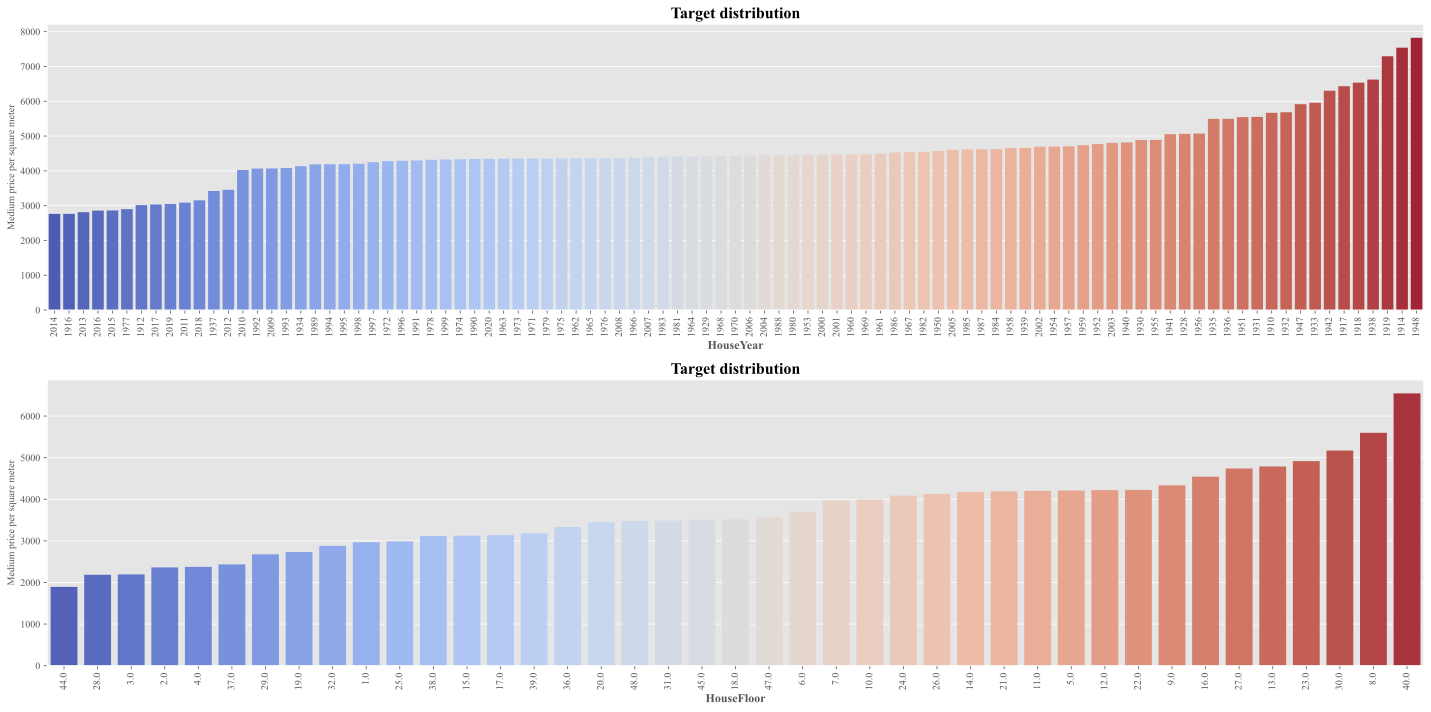

In [12]:
dftest.df_to_fill(df_train)
df_train = dftest.gap_filling(df_train)
dftest.target_analysis(df_train, ['HouseYear', 'HouseFloor'])
# dftest.target_analysis(df_train, ['DistrictId'])

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9997
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     9998 non-null   category
 1   Rooms          9998 non-null   float64 
 2   Square         9998 non-null   float32 
 3   LifeSquare     9998 non-null   float32 
 4   KitchenSquare  9998 non-null   float32 
 5   Floor          9998 non-null   float64 
 6   HouseFloor     9998 non-null   float64 
 7   HouseYear      9998 non-null   int32   
 8   Ecology_1      9998 non-null   float32 
 9   Ecology_2      9998 non-null   category
 10  Ecology_3      9998 non-null   category
 11  Social_1       9998 non-null   int8    
 12  Social_2       9998 non-null   int16   
 13  Social_3       9998 non-null   int16   
 14  Healthcare_1   9998 non-null   float32 
 15  Helthcare_2    9998 non-null   int8    
 16  Shops_1        9998 non-null   int8    
 17  Shops_2        9998 non-null   ca

## Feature engineering

In [14]:
class New_Features:

    def __init__(self):

        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.med_price_district = None
        self.med_price_year = None
        self.med_price_HouseFloor = None

    def fit(self, X):
        if 'Price' in X.columns:
            X['price_sq_meter'] = X['Price'] / X['Square']
            # медианные значения стоимости кв. метра с группировкой по категориям
            self.med_price_districtR = n_value_control(X, 'price_sq_meter', ['DistrictId', 'Rooms']).rename(
                columns={'cor_col': 'MedPriceScDistrictR'})
            self.med_price_year = n_value_control(X, 'price_sq_meter', ['HouseYear']).rename(
                columns={'cor_col': 'MedPriceScYear'})

    def transform(self, X):
        # медианные значения стоимости кв. метра с группировкой
        X = pd.merge(X, self.med_price_districtR['MedPriceScDistrictR'],  how='left', left_on=[
                     'DistrictId', 'Rooms'], right_on=['DistrictId', 'Rooms'])
        X['MedPriceScDistrictR'].fillna(
            self.med_price_districtR['MedPriceScDistrictR'].median(), inplace=True)

        X = pd.merge(X, self.med_price_year['MedPriceScYear'],  how='left', left_on=[
                     'HouseYear'], right_on=['HouseYear'])
        X['MedPriceScYear'].fillna(
            self.med_price_year['MedPriceScYear'].median(), inplace=True)
        # feature encoding
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        if 'Price' in X.columns:
            X.drop('Price', axis='columns', inplace=True)
        if 'target' in X.columns:
            X.drop('target', axis='columns', inplace=True)
        if 'Sc_cut' in X.columns:
            X.drop('Sc_cut', axis='columns', inplace=True)
        if 'SL' in X.columns:
            X.drop('SL', axis='columns', inplace=True)
        if 'price_sq_meter' in X.columns:
            X.drop('price_sq_meter', axis='columns', inplace=True)
        if 'price_per_room' in X.columns:
            X.drop('price_per_room', axis='columns', inplace=True)
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis='columns', inplace=True)

        X.drop(['Ecology_2',  'Social_1',
                'Ecology_3', 'Shops_2'], axis='columns', inplace=True) # отбор параметров
        return X

## Selection of forecasting models

In [15]:
f_gen = New_Features()
f_gen.fit(df_train)
df_train = f_gen.transform(df_train)
# df_train.to_csv('for_tunning.csv')

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9998 entries, 0 to 9997
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   DistrictId           9998 non-null   category
 1   Rooms                9998 non-null   float64 
 2   Square               9998 non-null   float32 
 3   LifeSquare           9998 non-null   float32 
 4   KitchenSquare        9998 non-null   float32 
 5   Floor                9998 non-null   float64 
 6   HouseFloor           9998 non-null   float64 
 7   HouseYear            9998 non-null   int32   
 8   Ecology_1            9998 non-null   float32 
 9   Social_2             9998 non-null   int16   
 10  Social_3             9998 non-null   int16   
 11  Helthcare_2          9998 non-null   int8    
 12  Shops_1              9998 non-null   int8    
 13  MedPriceScDistrictR  9998 non-null   float32 
 14  MedPriceScYear       9998 non-null   float32 
dtypes: category(1), float

In [17]:
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

In [18]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor

# тестировался RandomForestRegressor - max 0.749
# GradientBoostingRegressor - max 0.742
# XGBoostRegressor - max 0.752


In [19]:
X_train, X_valid, y2_train, y_valid = train_test_split(
    df_train, y_train, test_size=0.33, shuffle=True, random_state=13)

In [20]:
from lightgbm import LGBMRegressor

In [21]:
model_lgb = LGBMRegressor(n_estimators=190, max_depth=5,  num_leaves=20,
                          random_state=13)
model_lgb.fit(X_train, y2_train)

LGBMRegressor(max_depth=5, n_estimators=190, num_leaves=20, random_state=13)

In [22]:
y_train_preds = model_lgb.predict(X_train)
y_test_preds = model_lgb.predict(X_valid)

In [23]:
cv_score = cross_val_score(model_lgb, df_train, y_train, scoring='r2', cv=KFold(
    n_splits=10, shuffle=True, random_state=13))
cv_score, cv_score.mean()

(array([0.80025283, 0.78367758, 0.7423076 , 0.78697175, 0.71501791,
        0.74192676, 0.80160986, 0.78529184, 0.81423855, 0.76855345]),
 0.7739848132585653)

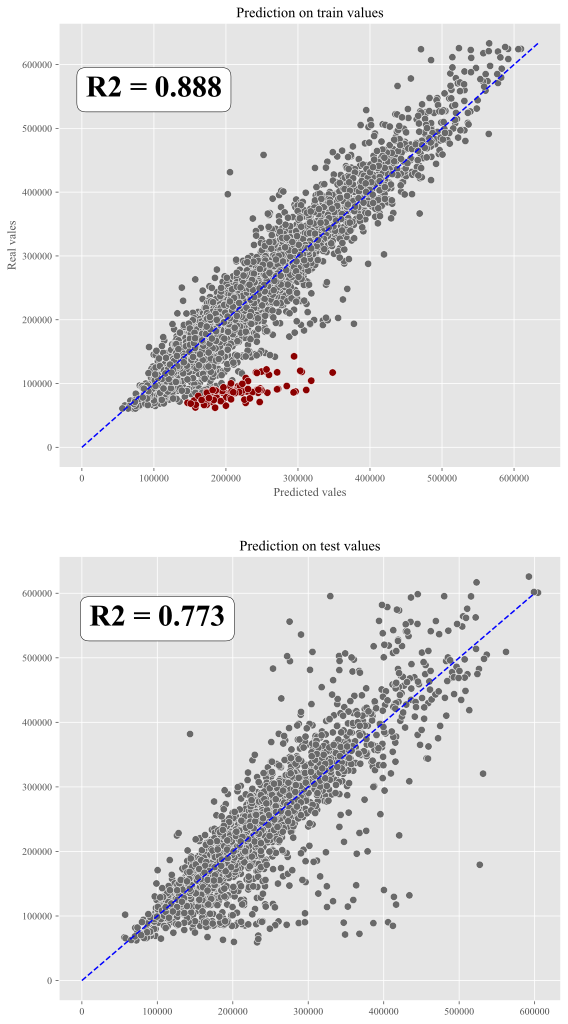

In [24]:
result_control(y2_train['Price'], y_train_preds,
               y_valid['Price'], y_test_preds)
# выбросы красным цветом- результат наличия в трейне квартир с одинаковыми(оч близкими) параметрами,
# но с сильно отличающейся ценой

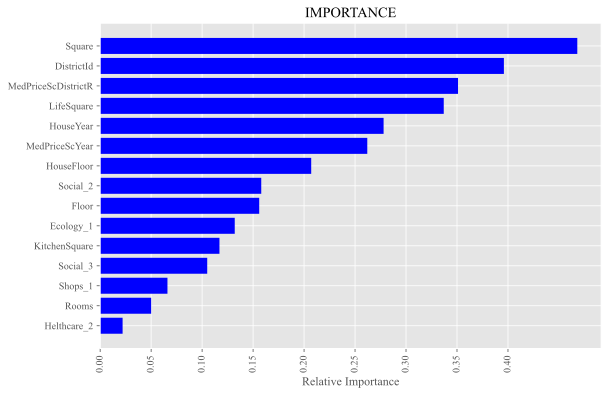

In [25]:
# feature importances
feature_name = X_train.columns
importances = model_lgb.feature_importances_
num = len(importances)
plt.figure(figsize=(9, 6))
plt.title('IMPORTANCE')
plt.barh(range(num), importances[np.argsort(importances)]/1000, color='b')
plt.yticks(range(num), feature_name[np.argsort(importances)])
plt.xticks(np.arange(0, 0.45, 0.05), rotation=90)
plt.xlabel('Relative Importance')
plt.show()

## TestDataset transforming. Price prediction

In [26]:
dftest.df_outliers(X_test)
X_test = dftest.gap_filling(X_test)
X_test = f_gen.transform(X_test)

In [27]:
df_train.shape, y_train.shape, X_test.shape

((9998, 15), (9998, 1), (5000, 15))

In [28]:
X_test['DistrictId'] = X_test['DistrictId'].astype('category')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   DistrictId           5000 non-null   category
 1   Rooms                5000 non-null   float64 
 2   Square               5000 non-null   float32 
 3   LifeSquare           5000 non-null   float32 
 4   KitchenSquare        5000 non-null   float32 
 5   Floor                5000 non-null   float64 
 6   HouseFloor           5000 non-null   float64 
 7   HouseYear            5000 non-null   int16   
 8   Ecology_1            5000 non-null   float32 
 9   Social_2             5000 non-null   int16   
 10  Social_3             5000 non-null   int16   
 11  Helthcare_2          5000 non-null   int8    
 12  Shops_1              5000 non-null   int8    
 13  MedPriceScDistrictR  5000 non-null   float32 
 14  MedPriceScYear       5000 non-null   float32 
dtypes: category(1), float

In [29]:
model_lgb.fit(df_train, y_train)

LGBMRegressor(max_depth=5, n_estimators=190, num_leaves=20, random_state=13)

In [30]:
predictions = model_lgb.predict(X_test)

In [31]:
df_to_send['Price'] = predictions

In [32]:
savename = "lgb_prediction" + str(round(cv_score.mean() * 1000)) + ".csv"
df_to_send.to_csv(savename)